# Implementation of a comparison of COMPAS data across all fairness functions

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid, load_dataset, mean_difference
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_mean, plot_median
from src.training import train
from src.distribution import ResamplingDistribution, COMPASDistribution

unable to import 'smart_open.gcs', disabling that module


## Uncalibrated Score: Benefit Difference: Benefit Difference

In [2]:
def calc_benefit(decisions, y, ips_weights):
    benefit = demographic_parity(decisions=decisions, y=y)

    if ips_weights is not None:
        benefit *= ips_weights

    return benefit

def fairness_gradient_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    benefit = calc_benefit(decisions, y, ips_weights)

    log_gradient = policy.log_policy_gradient(x, s)
    benefit_grad = log_gradient * benefit
        
    return mean_difference(benefit_grad, s)

def fairness_function(**fairness_kwargs):
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    benefit = calc_benefit(decisions, y, ips_weights)
        
    return mean_difference(benefit, s)

bias = True
# distribution = ResamplingDistribution(bias=bias, dataset=load_dataset("../dat/compas/compas.npz"), test_percentage=0.2)
distribution = COMPASDistribution(bias=bias, test_percentage=0.2)
dim_theta = distribution.feature_dim

print(dim_theta)

def util_func(**util_params):
    util = cost_utility(cost_factor=0.6, **util_params)
    return util

training_parameters = {    
    'save_path': './',
    'model':{
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'fairness_gradient_function': fairness_gradient_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'learn_on_entire_history': False,
        'use_sensitve_attributes': False,
        'bias': bias,
        'initial_theta': np.zeros((dim_theta))
    },
    'parameter_optimization': {
        'time_steps':200,
        'epochs': 40,
        'batch_size':64,
        'learning_rate': 0.1,
        'decay_rate': 1,
        'decay_step': 10000,
        'num_decisions': 4096
    },
    'data': {
        'distribution': distribution,
        'num_test_samples': None
    }
}

7


---------- Single training run for fixed lambda ----------


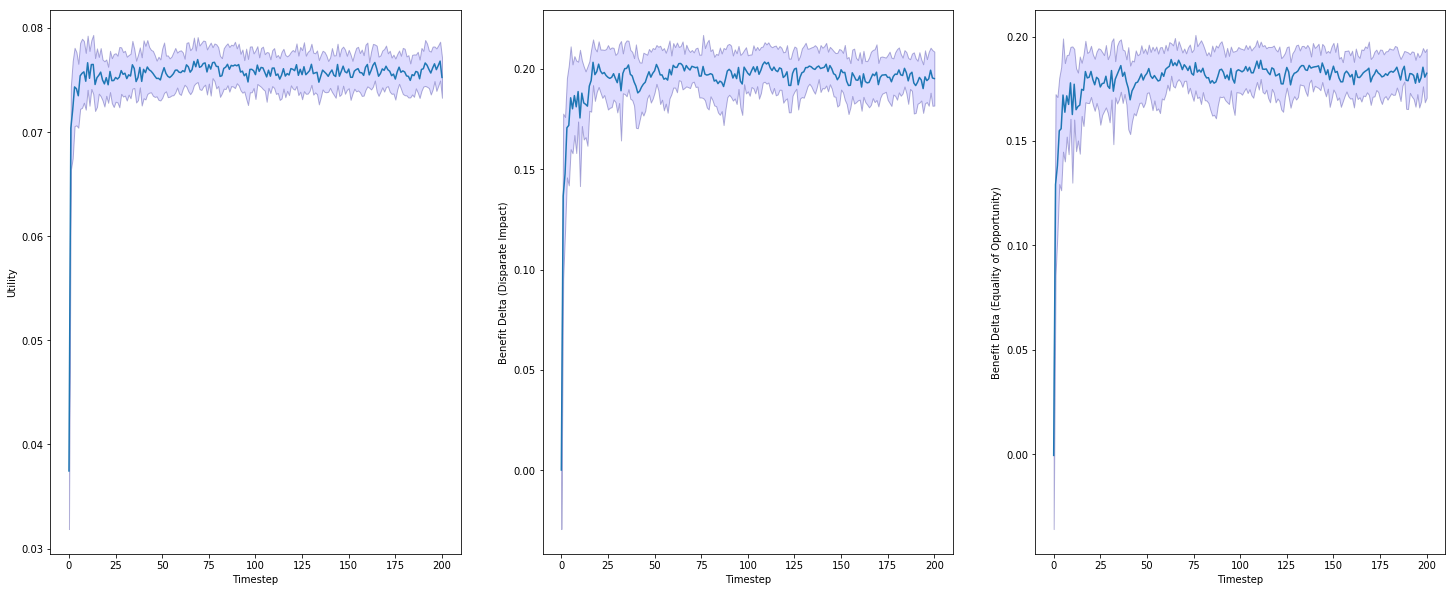

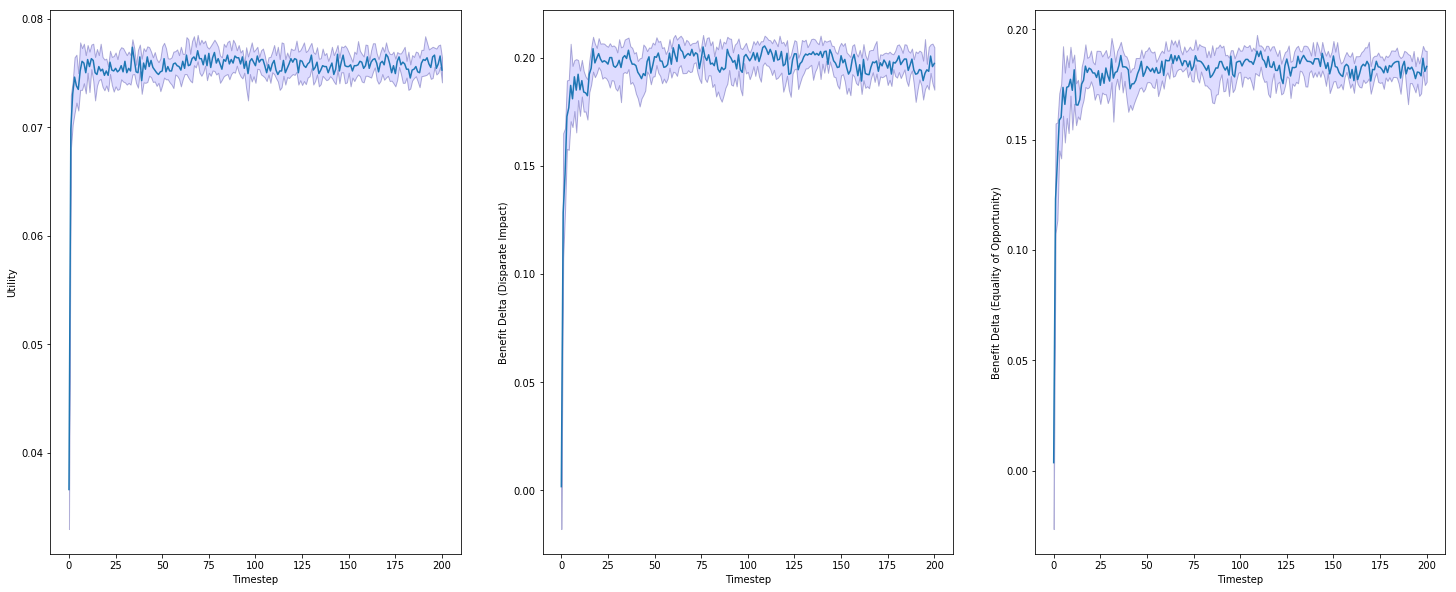

In [3]:
training_parameters["experiment_name"] = "exp-011-compas-no-fairness"
training_parameters["model"]["initial_lambda"] = 0.0

statistics, _, run_path = train(training_parameters, iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_time.png".format(run_path))
plot_median(statistics, "{}/results_median_time.png".format(run_path))

---------- Training with fixed lambdas ----------


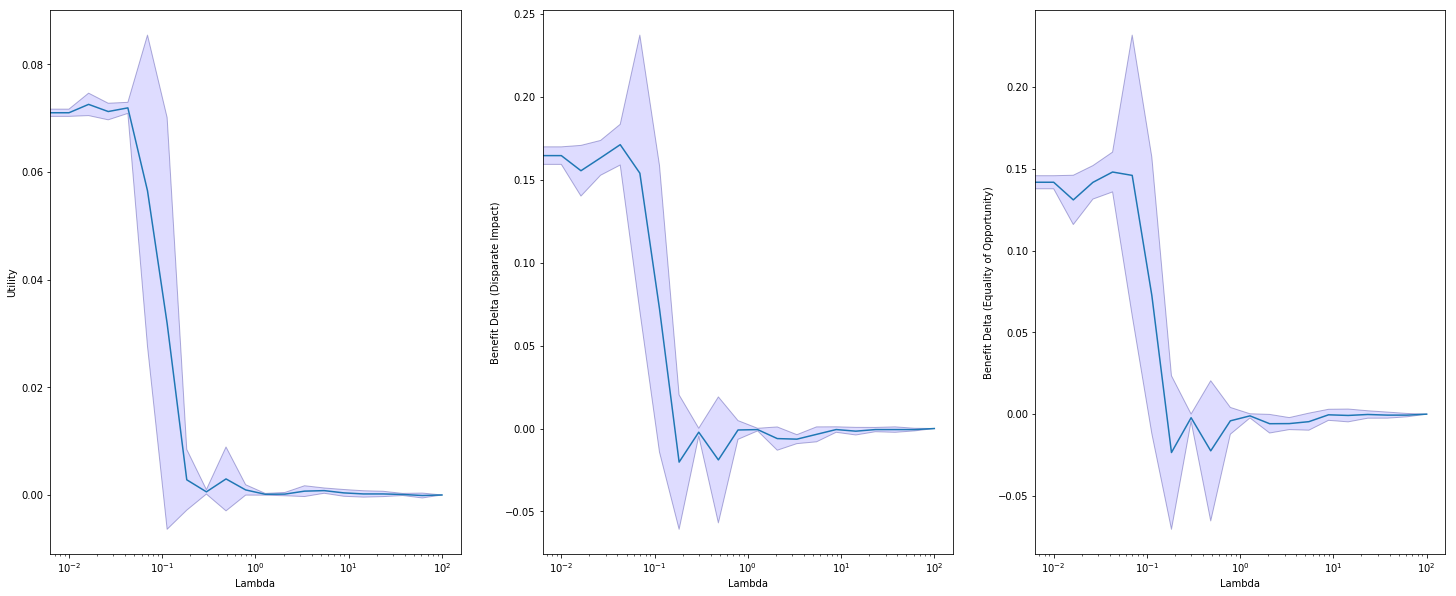

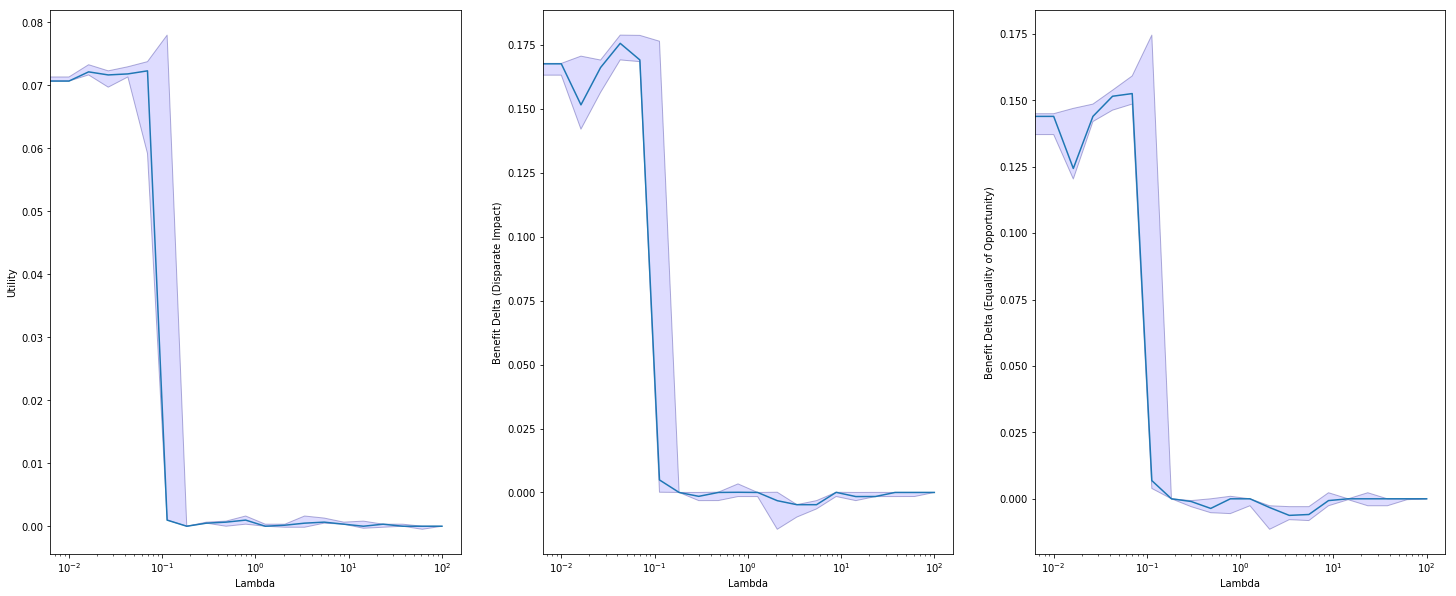

In [13]:
training_parameters["experiment_name"] = "exp-011-compas-benefit-lambda-sweep"
lambdas = np.logspace(-2, 2, base=10, endpoint=True, num=20)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])
training_parameters["model"]["initial_lambda"] = lambdas

statistics, model_parameters, run_path = train(training_parameters, iterations=5, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path))

---------- Training both theta and lambda ----------


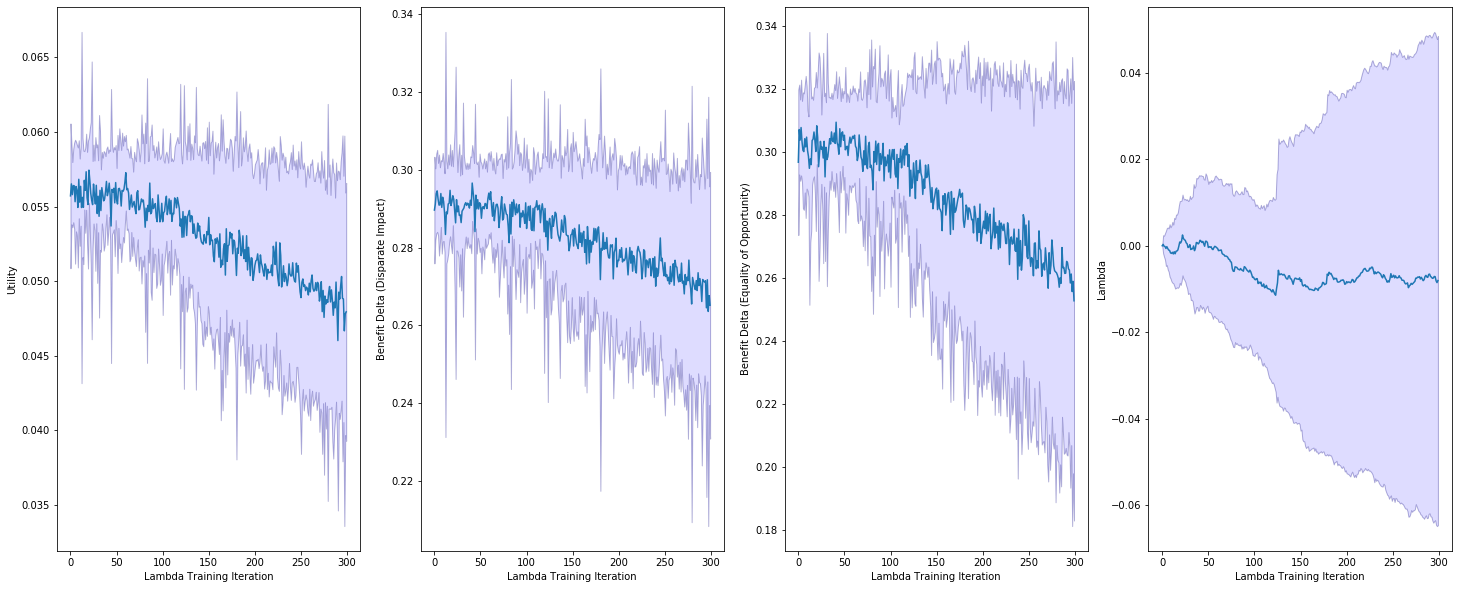

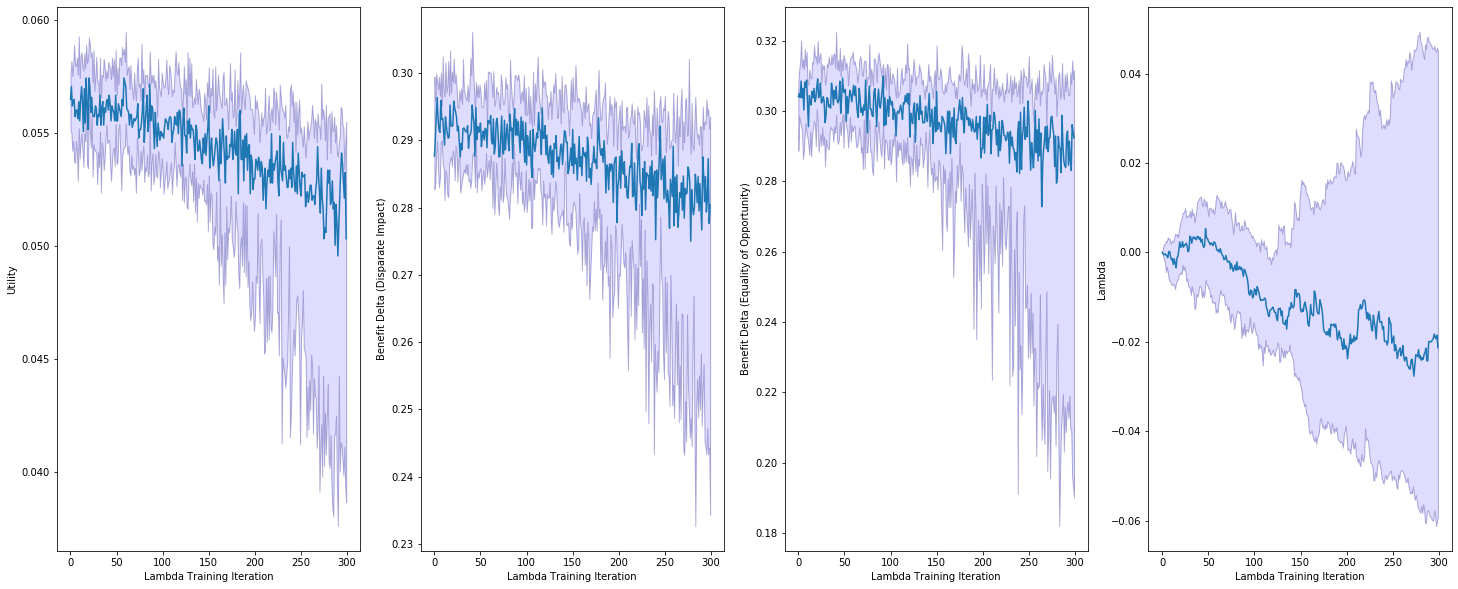

In [6]:
training_parameters["experiment_name"] = "exp-011-compas-benefit-dual-gradient"
training_parameters["model"]["initial_lambda"] = 0.0
training_parameters["lagrangian_optimization"] = {
    'iterations': 300,
    'epochs': 1,
    'batch_size':256,
    'learning_rate': 0.01,
    'decay_rate': 1,
    'decay_step': 1000000,
    'num_decisions': 128 * 512
}

statistics, model_parameters, run_path = train(training_parameters, iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path), model_parameters=model_parameters)
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path), model_parameters=model_parameters)

# Covariance of decision

In [24]:
def calc_covariance(x, s, policy, ips_weights, decisions):    
    s_0_to_m1 = -(1 - s) 
    new_s = s + s_0_to_m1
    
    if ips_weights is not None:
        mu_s = np.mean(new_s * ips_weights, axis=0)
        decisions *= ips_weights
    else:
        mu_s = np.mean(new_s, axis=0)

    covariance = (new_s - mu_s) * decisions
    
    # if ips_weights is not None:
    #     mu_s = np.mean(s * ips_weights, axis=0)
    #     decisions *= ips_weights
    # else:
    #     mu_s = np.mean(s, axis=0)
    # 
    # covariance = (s - mu_s) * decisions
    return covariance

def fairness_gradient_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    ips_weights = fairness_kwargs["ips_weights"]
    decisions = fairness_kwargs["decisions"]
    
    covariance = calc_covariance(x, s, policy, ips_weights,decisions)

    log_policy_gradient = policy.log_policy_gradient(x, s)
    covariance_grad = log_policy_gradient * covariance

    return np.mean(covariance_grad, axis=0)

def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    ips_weights = fairness_kwargs["ips_weights"]
    decisions = fairness_kwargs["decisions"]
    
    covariance = calc_covariance(x, s, policy, ips_weights,decisions)
    return np.mean(covariance, axis=0)

bias = True
distribution = ResamplingDistribution(bias=bias, dataset=load_dataset("../dat/compas/compas.npz"), test_percentage=0.2)
dim_theta = distribution.feature_dim

def util_func(**util_params):
    util = cost_utility(cost_factor=0.6, **util_params)
    return util

training_parameters = {    
    'save_path': './',
    'model':{
        'benefit_function': demographic_parity,
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'fairness_gradient_function': fairness_gradient_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'learn_on_entire_history': False,
        'use_sensitve_attributes': False,
        'bias': bias,
        'initial_theta': np.zeros((dim_theta))
    },
    'parameter_optimization': {
        'time_steps':200,
        'epochs': 40,
        'batch_size':64,
        'learning_rate': 0.1,
        'decay_rate': 1,
        'decay_step': 10000,
        'num_decisions': 4096
    },
    'data': {
        'distribution': distribution,
        'num_test_samples': None
    }
}


---------- Training with fixed lambdas ----------


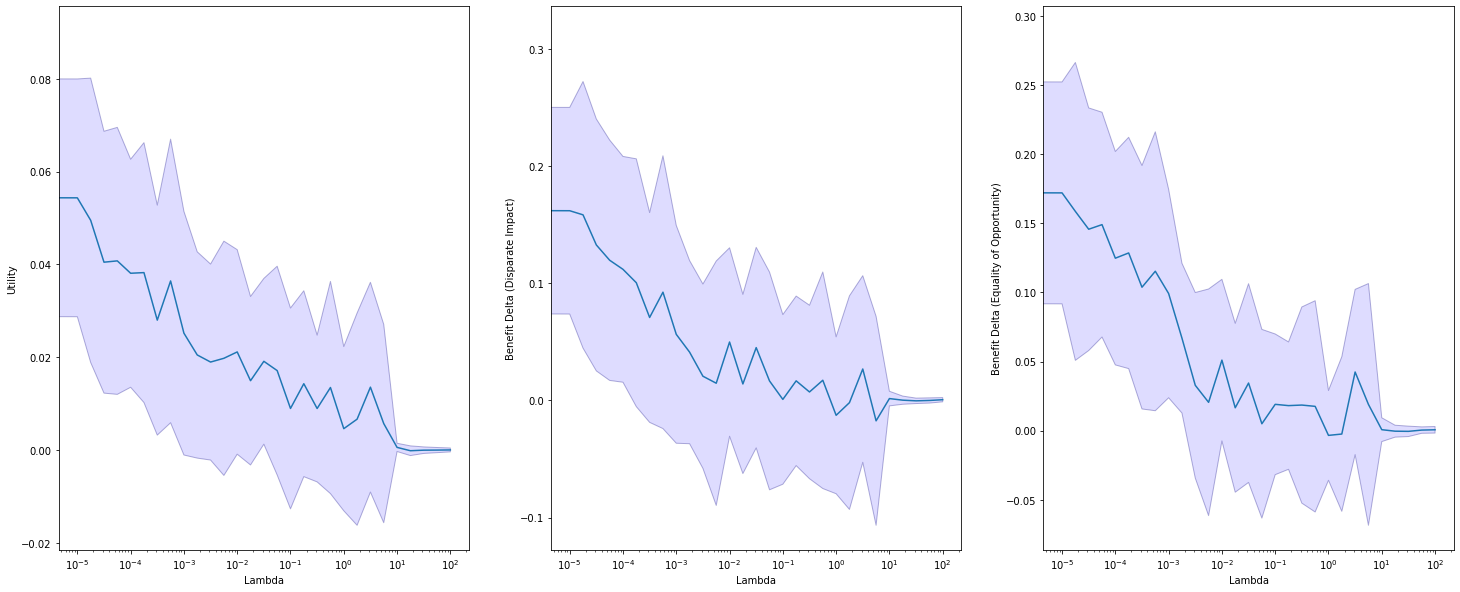

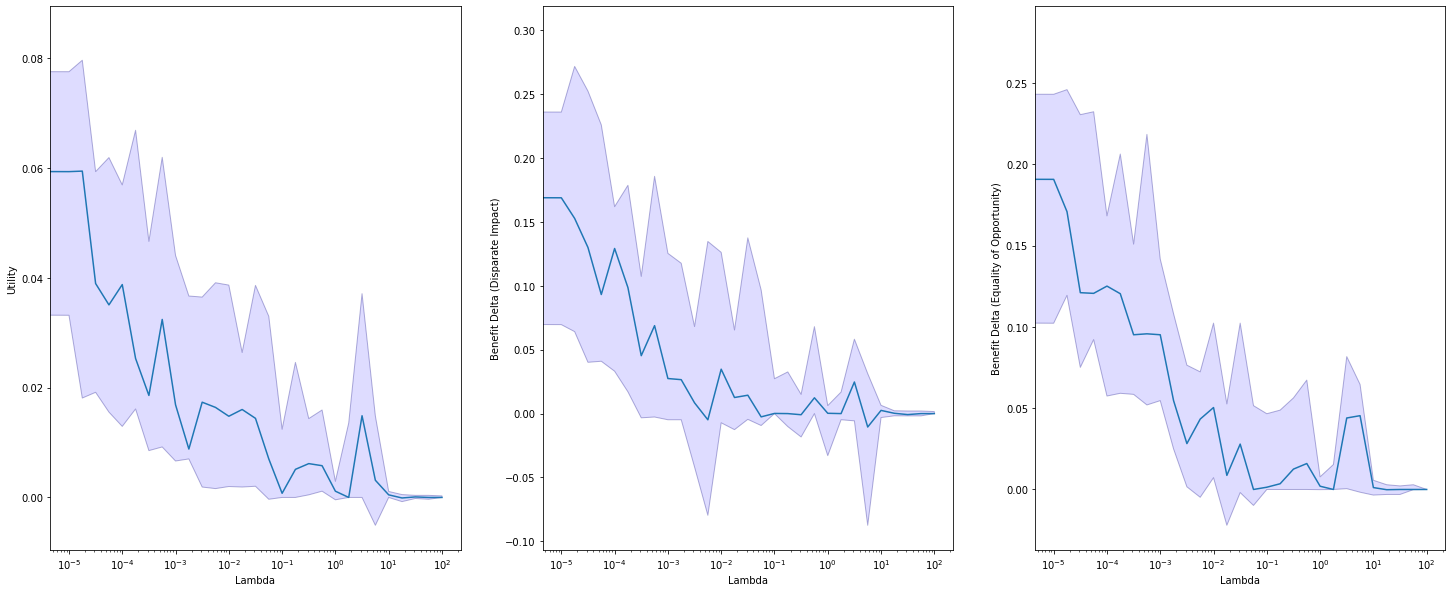

In [25]:
training_parameters["experiment_name"] = "exp-011-compas-covdecision-lambda-sweep"
lambdas = np.logspace(-5, 2, base=10, endpoint=True, num=29)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])
training_parameters["model"]["initial_lambda"] = lambdas

statistics, _, run_path = train(training_parameters, iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path))

---------- Training both theta and lambda ----------


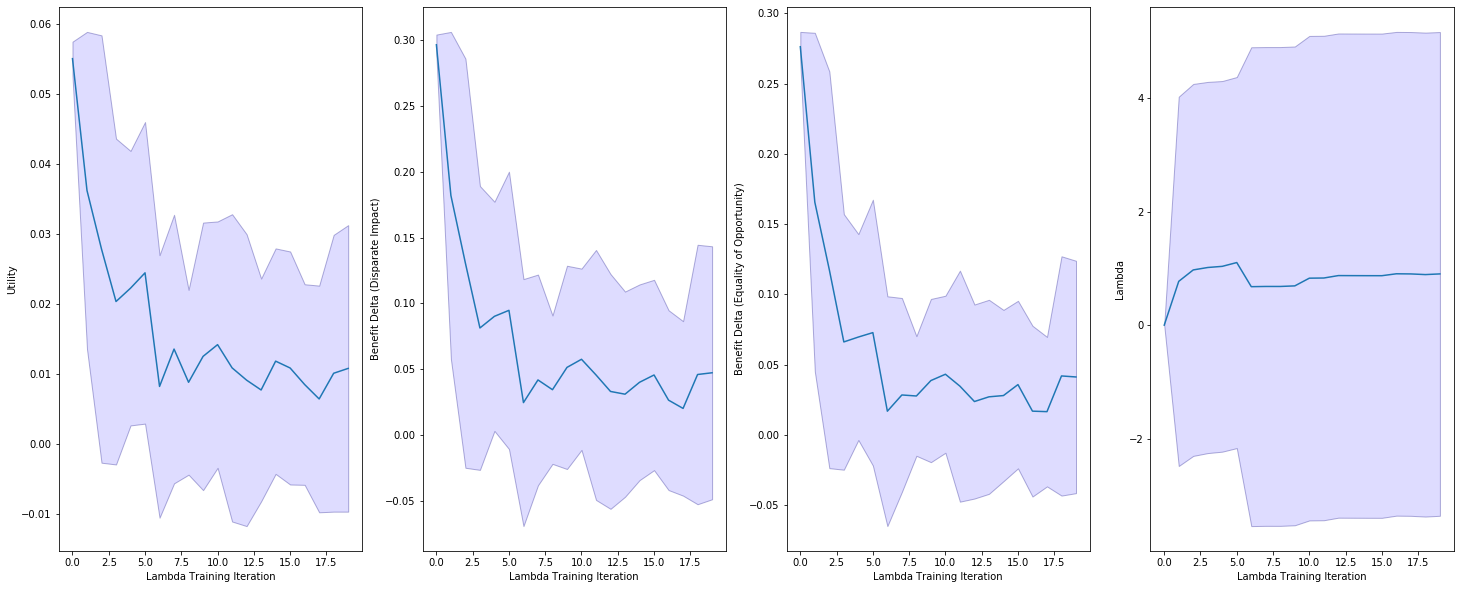

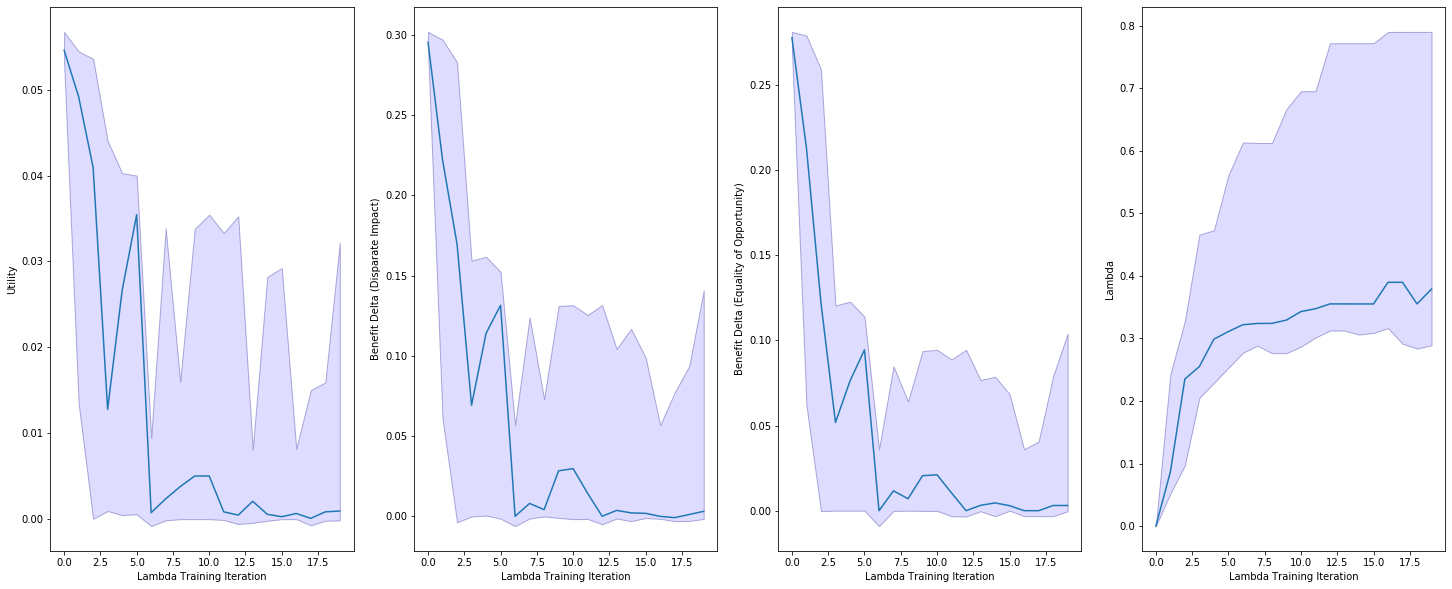

In [27]:
training_parameters["experiment_name"] = "exp-011-compas-covdecision-dual-gradient"
training_parameters["model"]["initial_lambda"] = 0.0
training_parameters["lagrangian_optimization"] = {
    'iterations': 20,
    'epochs': 10,
    'batch_size':256,
    'learning_rate': 0.01,
    'decay_rate': 1,
    'decay_step': 10000,
    'num_decisions': 128 * 256
}

statistics, model_parameters, run_path = train(training_parameters, iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path), model_parameters=model_parameters)
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path), model_parameters=model_parameters)
